In [1]:
pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os


In [6]:
os.getcwd()

'/content/drive/MyDrive/kaggle2'

In [5]:
os.chdir('/content/drive/MyDrive/kaggle2')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
## 환경설정: 필요한 패키지 확인
import gc
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import combinations

from matplotlib import pyplot as plt
import seaborn as sns
import missingno
from termcolor import colored, cprint

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve
from xgboost import XGBClassifier

# configurations
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette('dark')

SIGMA = 3
SEPARATOR = colored(200*'=', 'red')
teams_worldcup = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'IR Iran', 'USA',
                  'Wales', 'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 
                  'Australia', 'Denmark', 'Tunisia', 'Spain', 'Costa Rica', 'Germany', 
                  'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia', 'Brazil', 'Serbia', 
                  'Switzerland', 'Cameroon', 'Portugal', 'Ghana', 'Uruguay', 'Korea Republic']

In [8]:
df = pd.read_csv('/content/drive/MyDrive/kaggle2/matchesnewest_na.csv',encoding='latin1')
##우리가 전처리한 데이터 판다스 패키지를 통해 가져오기

display(df.sample(5))
print(SEPARATOR)
display(df.describe())
print(SEPARATOR)
display(df.select_dtypes(include='object').describe())
print(SEPARATOR)
display(df.info())
print(SEPARATOR)
display(df.dtypes)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_sum,away_sum,year,home_win,home_draw,home_lose
748,2019.6.11,Germany,Estonia,Europe,Europe,13,96,1570,1240,8,0,UEFA Euro qualification,Mainz,Germany,False,No,Win,90.0,62.0,83.0,87.0,85.0,69.0,NaN,63.0,345.0,194.0,2019,True,False,False
516,2019.3.18,Solomon Islands,Vanuatu,Oceania,Oceania,143,163,1073,996,3,1,Friendly,Honiara,Solomon Islands,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,True,False,False
1525,2020.1.12,Kosovo,Sweden,Europe,Europe,115,17,1174,1579,0,1,Friendly,Doha,Qatar,True,No,Lose,67.0,78.0,71.0,74.7,73.8,77.8,79.3,77.8,286.5,312.9,2020,False,False,True
2186,2021.6.11,Malaysia,Vietnam,Asia,Asia,153,92,1040,1258,1,2,FIFA World Cup qualification,Dubai,United Arab Emirates,True,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,False,False,True
1286,2019.10.15,Aruba,Jamaica,North America,North America,195,47,890,1435,0,6,CONCACAF Nations League,Willemstad,CuraÃ§ao,True,No,Lose,NaN,76.0,NaN,NaN,NaN,74.0,69.3,70.8,NaN,290.1,2019,False,False,True


,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_sum,away_sum,year
count,3467.000000,3467.000000,3467.000000,3467.000000,3467.000000,3467.000000,2054.000000,1900.000000,1957.000000,2013.000000,2061.000000,1809.000000,1936.000000,1962.000000,2354.000000,2302.000000,3467.000000
mean,83.366022,88.871070,1304.705221,1281.483127,1.583790,1.061725,75.500974,74.759474,74.559121,76.231495,75.238234,73.971918,75.188585,74.612793,258.925743,246.660990,2020.070666
std,56.622617,56.277631,228.223085,224.036708,1.639671,1.292349,7.715013,7.721013,5.134922,6.351157,5.620136,5.031592,6.254722,5.678176,88.198221,93.518734,1.338722
min,1.000000,1.000000,776.000000,776.000000,0.000000,0.000000,51.000000,51.000000,60.000000,55.000000,58.800000,60.000000,55.000000,58.800000,51.000000,51.000000,2018.000000
25%,34.000000,41.000000,1131.000000,1111.000000,0.000000,0.000000,70.000000,69.000000,71.000000,72.000000,72.000000,70.000000,71.000000,70.800000,221.900000,206.000000,2019.000000
50%,75.000000,82.000000,1325.000000,1295.000000,1.000000,1.000000,75.000000,75.000000,74.200000,76.300000,75.000000,74.000000,75.300000,75.000000,298.000000,292.350000,2020.000000
75%,126.000000,131.000000,1480.500000,1454.500000,2.000000,2.000000,81.000000,80.000000,78.000000,80.000000,79.200000,77.500000,79.300000,78.200000,311.700000,309.300000,2021.000000
max,211.000000,211.000000,1832.000000,1832.000000,15.000000,14.000000,91.000000,91.000000,85.200000,91.000000,86.000000,85.200000,91.000000,86.000000,345.000000,345.000000,2022.000000


,date,home_team,away_team,home_team_continent,away_team_continent,tournament,city,country,shoot_out,home_team_result
count,3467,3467,3467,3467,3467,3467,3467,3467,3467,3467
unique,457,209,209,6,6,33,610,201,2,3
top,2022.3.29,USA,Panama,Europe,Europe,Friendly,Doha,USA,No,Win
freq,55,44,29,1239,1189,898,88,151,3415,1702


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467 entries, 0 to 3466
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           3467 non-null   object 
 1   home_team                      3467 non-null   object 
 2   away_team                      3467 non-null   object 
 3   home_team_continent            3467 non-null   object 
 4   away_team_continent            3467 non-null   object 
 5   home_team_fifa_rank            3467 non-null   int64  
 6   away_team_fifa_rank            3467 non-null   int64  
 7   home_team_total_fifa_points    3467 non-null   int64  
 8   away_team_total_fifa_points    3467 non-null   int64  
 9   home_team_score                3467 non-null   int64  
 10  away_team_score                3467 non-null   int64  
 11  tournament                     3467 non-null   object 
 12  city                           3467 non-null   o

None

date                              object
home_team                         object
away_team                         object
home_team_continent               object
away_team_continent               object
home_team_fifa_rank                int64
away_team_fifa_rank                int64
home_team_total_fifa_points        int64
away_team_total_fifa_points        int64
home_team_score                    int64
away_team_score                    int64
tournament                        object
city                              object
country                           object
neutral_location                    bool
shoot_out                         object
home_team_result                  object
home_team_goalkeeper_score       float64
away_team_goalkeeper_score       float64
home_team_mean_defense_score     float64
home_team_mean_offense_score     float64
home_team_mean_midfield_score    float64
away_team_mean_defense_score     float64
away_team_mean_offense_score     float64
away_team_mean_m

# Handle Nulls

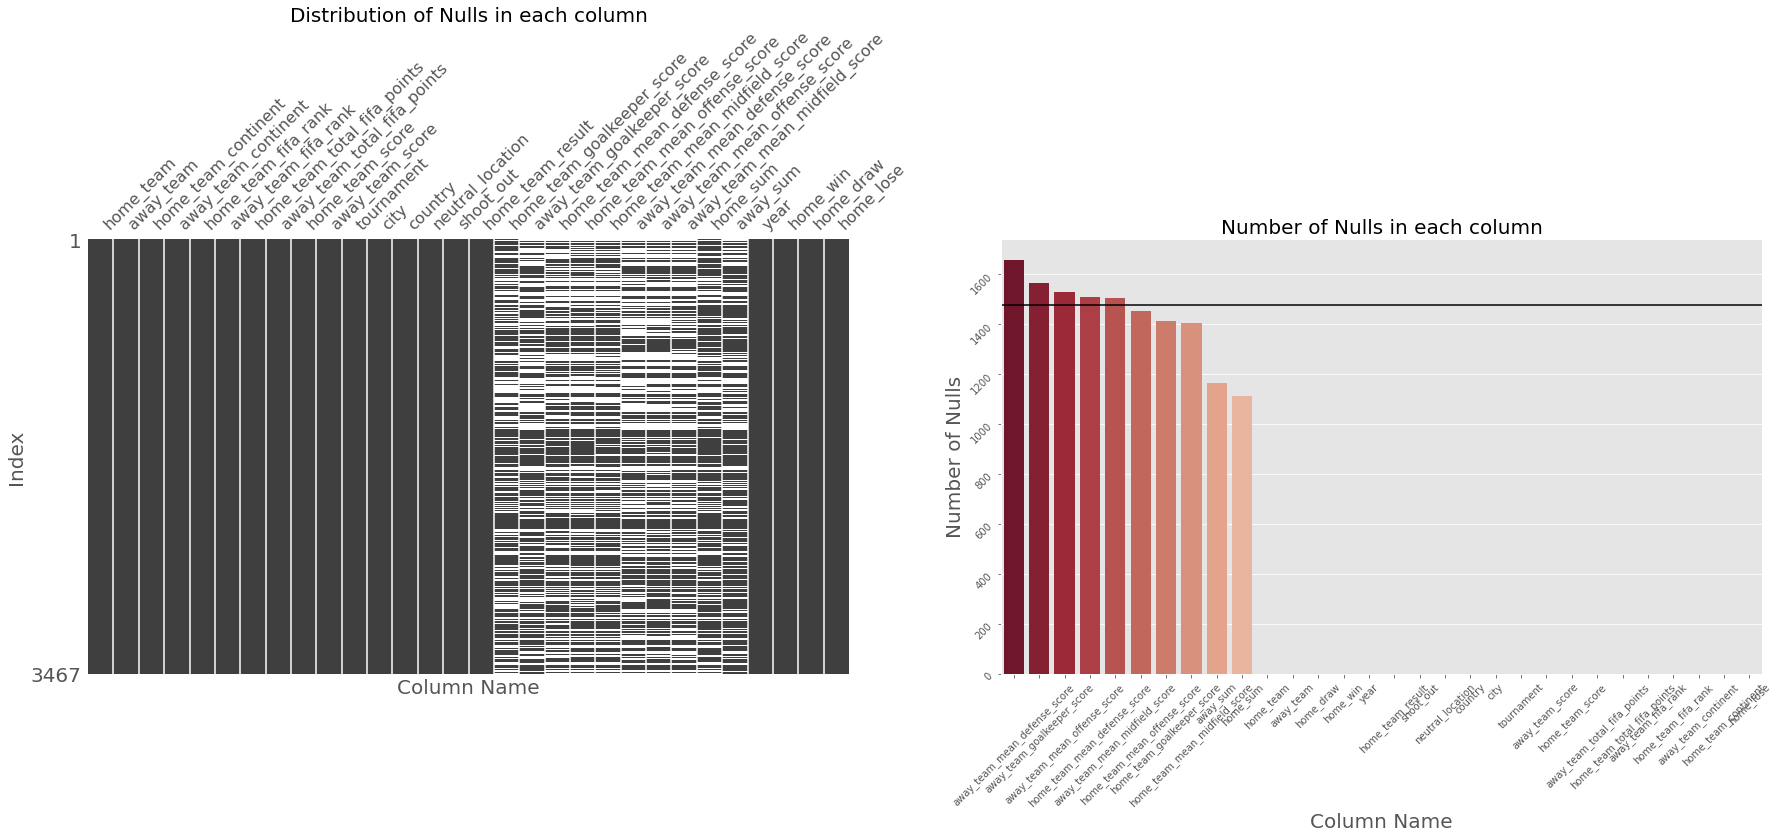

In [9]:
##각 열의 널값 분포 파악 missingno, seaborn 라이브러리의 matrix, barplot 메소드 사용하여 그래프로 시각화
per_date = df.set_index('date').copy()
Nulls = per_date.isnull().sum().sort_values(ascending=False)
##numpy로 중앙값 처리
median = np.median(Nulls[Nulls>0].values)

##subplot은 그림을 그릴 수 있는 객체를 만들고 그림을 그릴 개수를 정해준다.(1행,2열)즉 2개의 그림을 그릴 것이다.
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

##missingno의 martix 시각화
missingno.matrix(per_date, ax=axs[0])
axs[0].set_title('Distribution of Nulls in each column',
                 size=20);axs[0].set_xlabel('Column Name', size=20);axs[0].set_ylabel('Index', size=20);

##seaborn 라이브러리 barplot 메소드 활용
sns.barplot(x=Nulls.index, y=Nulls.values, ax=axs[1], palette='RdBu')

##중앙값에 선 그리기
axs[1].tick_params(labelrotation=45)
axs[1].axhline(median, color='#000000')
axs[1].set_title('Number of Nulls in each column',
                 size=20);axs[1].set_xlabel('Column Name', size=20);axs[1].set_ylabel('Number of Nulls', size=20);


In [10]:
##연별 널값 비율
##연도만 추출
df['year'] = pd.to_datetime(df['date']).dt.year
##연도당 null 값의 수를 null수의 평균을 총합하는 함수를 만들어 개수를 세어주었음.
nulls_per_year = pd.pivot_table(df, index=['year'], aggfunc=lambda x : x.isnull().mean() / 0.08).sum(1).sort_index()
##그래프그리기
fig = go.Figure(go.Scatter(x=nulls_per_year.index, y=nulls_per_year.values, mode='lines+markers'))
fig.update_layout(xaxis={'title':{'text':'year', 'font':{'size':20, 'color':'#7F1431'}}}, 
                  yaxis={'title':{'text':'Percentage of Nulls', 'font':{'size':20, 'color':'#7F1431'}}}, 
                  title={'text':"Percentage of nulls every year", 'font':{'size':25}})

In [11]:
# fill nulls in score columns mean
df=df.fillna(df.mean())

In [13]:
df['year'] = pd.to_datetime(df['date']).dt.year
nulls_per_year = pd.pivot_table(df, index=['year'], aggfunc=lambda x : x.isnull().mean() / 0.08).sum(1).sort_index()
fig = go.Figure(go.Scatter(x=nulls_per_year.index, y=nulls_per_year.values, mode='lines+markers'))
fig.update_layout(xaxis={'title':{'text':'year', 'font':{'size':20, 'color':'#7F1431'}}}, 
                  yaxis={'title':{'text':'Percentage of Nulls', 'font':{'size':20, 'color':'#7F1431'}}}, 
                  title={'text':"Percentage of nulls every year", 'font':{'size':25}})

# Duplicates

In [15]:
print(f"Number of Duplicte rows in this dataset: {colored(df.duplicated().sum(), 'red')}")

Number of Duplicte rows in this dataset: 0


# Outliers

In [16]:
##이상치 
##column에서 object를 제외한 수치형 데이터만 가져옴.
columns = df.select_dtypes(exclude='object').columns
n_cols = 2
n_rows = len(columns) // n_cols + 1
## fig는 보통 그래프 subplot은 여러개의 그래프를 만드는 메소드
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=columns)
##enumerate는 객체에 인덱스를 부여하는 데이터타입 column이라는 리스트에 인덱스를 부여해준다.
for i, col in enumerate(columns):
    ##boxplot생성, min,max, quantile표시
    fig.add_trace(go.Box(x=df[col], name=col),
                  row=i//n_cols+1, col=int(i%n_cols)+1)
    
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(height=1080)
fig.show()

In [17]:
##4개의 그래프를 그릴것이기 때문에 subplot(2,2)
fig = make_subplots(2, 2, subplot_titles=['Home team points distribution', 'Away team points distribution', 'Home team points per year', 'Away team points per year'])
##첫번째 그래프는 home_team_fifa_point에 대한 그래프
trace1 = go.Histogram(x=df['home_team_total_fifa_points'], name='Home Team')
fig.add_trace(trace1, row=1, col=1)
## 두 번째는 away_team_fifa_pint
trace2 = go.Histogram(x=df['away_team_total_fifa_points'], name='Away Team')
fig.add_trace(trace2, row=1, col=2)

##연도별 홈팀,어웨이팀의 피파포인트 분포
home_team_points_per_year = df.groupby('year')['home_team_total_fifa_points'].mean()
away_team_points_per_year = df.groupby('year')['away_team_total_fifa_points'].mean()


trace1 = go.Bar(x=home_team_points_per_year.index, y=home_team_points_per_year.values, name='home')
fig.add_trace(trace1, 2, 1)
trace2 = go.Bar(x=away_team_points_per_year.index, y=away_team_points_per_year.values, name='away')
fig.add_trace(trace2, 2, 2)

In [18]:

def mode(arr):
    srtd_lst, cnt = np.unique(arr, return_counts=True)
    return srtd_lst[np.argmax(cnt)]

# Home win | draw | lose
df['home_win'] = df['home_team_result'].apply(lambda x : x=='Win')
df['home_draw'] = df['home_team_result'].apply(lambda x : x=='Draw')
df['home_lose'] = df['home_team_result'].apply(lambda x : x=='Lose')

# per team table
per_team = pd.DataFrame(df.groupby('home_team')['home_win'].sum())
per_team['home_draw'] = df.groupby('home_team')['home_draw'].sum().values
per_team['home_lose'] = df.groupby('home_team')['home_lose'].sum().values

per_team['away_win']  = df.groupby('away_team')['home_lose'].sum().values
per_team['away_draw']  = df.groupby('away_team')['home_draw'].sum().values
per_team['away_lose']  = df.groupby('away_team')['home_win'].sum().values

per_team['continent'] = df.groupby('home_team')['home_team_continent'].apply(mode).values

per_team['avg_FIFA_points'] = (df.groupby('home_team')['home_team_total_fifa_points'].mean().values 
                               + df.groupby('away_team')['away_team_total_fifa_points'].mean().values) / 2
per_team['median_FIFA_rank'] = df.groupby('home_team')['home_team_fifa_rank'].median().values

per_team['home_goal_scored'] = df.groupby(['home_team'])['home_team_score'].sum()
per_team['home_goal_conceded'] = df.groupby(['home_team'])['away_team_score'].sum()
per_team['away_goal_scored'] = df.groupby(['away_team'])['away_team_score'].sum()
per_team['away_goal_conceded'] = df.groupby(['away_team'])['home_team_score'].sum()



per_team.head()

,home_win,home_draw,home_lose,away_win,away_draw,away_lose,continent,avg_FIFA_points,median_FIFA_rank,home_goal_scored,home_goal_conceded,away_goal_scored,away_goal_conceded
home_team,,,,,,,,,,,,,
Afghanistan,1,2,3,2,4,6,Asia,1054.708333,149.0,5,8,11,23
Albania,10,4,7,6,4,9,Europe,1365.898496,65.0,26,22,18,25
Algeria,17,6,2,17,4,3,Africa,1450.544167,38.0,64,14,40,19
American Samoa,1,0,2,0,0,1,Oceania,908.000000,190.0,8,15,0,13
Andorra,5,7,12,1,3,15,Europe,1069.119518,142.0,13,40,8,43


# EDA

In [20]:
#출전국 피파랭킹 오름차순
teams_df = pd.read_csv('/content/drive/MyDrive/kaggle2/Qatar2022-teams (1).csv', sep=";")

ranks = []
for x in teams_worldcup:
    rank_df = df[(df['home_team']== x) | (df['away_team']== x)].sort_values(['date','home_team_fifa_rank',
                                                                             'away_team_fifa_rank'], 
                                                                            ascending=[False,True,True]).iloc[0]
    if rank_df['home_team']==x:
        rank = rank_df['home_team_fifa_rank']
    else:
        rank = rank_df['away_team_fifa_rank']
    ranks.append(rank)

team_ranks = pd.DataFrame({'Team':teams_worldcup, 'Rank': ranks}).sort_values('Rank').reset_index(drop=True)
team_ranks.index += 1
team_ranks

,Team,Rank
1,Brazil,1
2,Belgium,2
3,France,3
4,Argentina,4
5,England,5
6,Spain,7
7,Portugal,8
8,Mexico,9
9,Netherlands,10
10,Denmark,11


In [21]:
print('\nTop 10 team ranking:\n' )
team_ranks[:10]


Top 10 team ranking:



,Team,Rank
1,Brazil,1
2,Belgium,2
3,France,3
4,Argentina,4
5,England,5
6,Spain,7
7,Portugal,8
8,Mexico,9
9,Netherlands,10
10,Denmark,11


In [22]:
goalkeeper_score = []
for x in teams_worldcup:
    gk_score = np.round((df[df["home_team"]==x]['home_team_goalkeeper_score'].mean() +
                         df[df["away_team"]==x]['away_team_goalkeeper_score'].mean())/2, 2)
    goalkeeper_score.append(gk_score)

goalkeeper_scores = pd.DataFrame({'Team':teams_worldcup, 
                                  'Gk score': goalkeeper_score}).sort_values('Gk score',
                                                                             ascending=False).reset_index(drop=True)
goalkeeper_scores.index += 1
goalkeeper_scores

,Team,Gk score
1,Germany,90.0
2,Belgium,90.0
3,Brazil,89.0
4,Costa Rica,88.0
5,France,87.0
6,Poland,86.0
7,Senegal,86.0
8,Switzerland,85.0
9,Morocco,84.0
10,Argentina,84.0


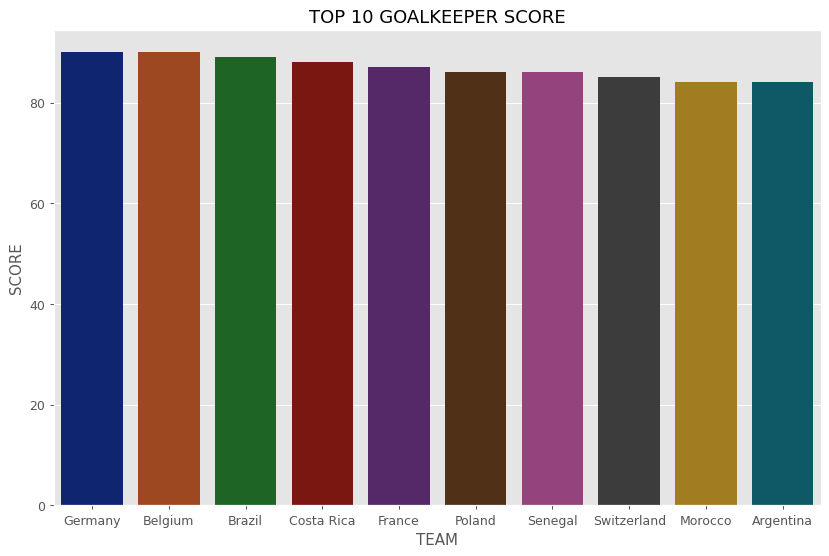

In [24]:
plt.figure(figsize=(11,7), dpi=90)
ax = sns.barplot(data=goalkeeper_scores[:10], x='Team', y='Gk score')

plt.xlabel('TEAM')
plt.ylabel('SCORE')
plt.title('TOP 10 GOALKEEPER SCORE');

In [25]:
defence_score = []
for x in teams_worldcup:
    df_score = np.round((df[df["home_team"]==x]['home_team_mean_defense_score'].mean() + df[df["away_team"]==x]['away_team_mean_defense_score'].mean())/2, 2)
    defence_score.append(df_score)

defence_scores = pd.DataFrame({'Team':teams_worldcup, 'Df score': defence_score}).sort_values('Df score', ascending=False).reset_index(drop=True)
defence_scores.index += 1
defence_scores

,Team,Df score
1,Portugal,84.00
2,Brazil,84.00
3,France,83.00
4,Germany,83.00
5,Spain,83.00
6,Netherlands,82.06
7,Argentina,82.00
8,England,82.00
9,Morocco,81.00
10,Uruguay,80.00


AttributeError: ignored

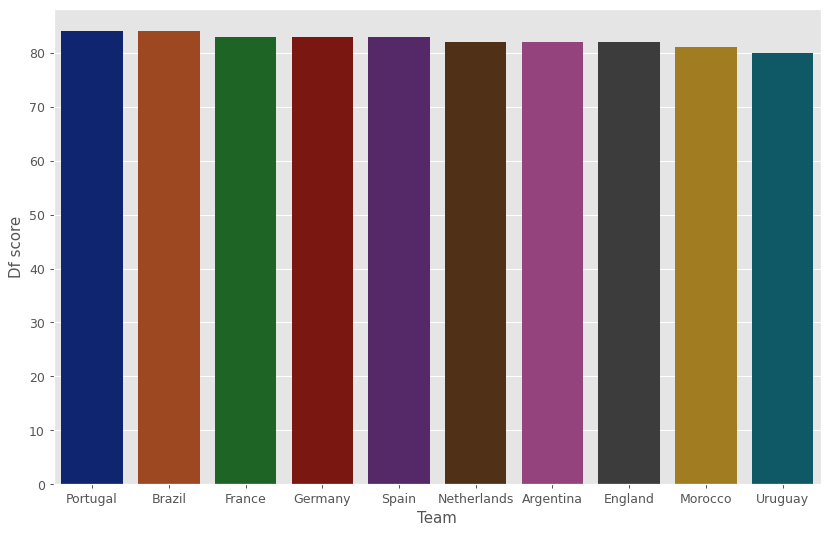

In [26]:
plt.figure(figsize=(11,7), dpi=90)
ax = sns.barplot(data=defence_scores[:10], x='Team', y='Df score')
ax.bar_label(ax.containers[0])
plt.xlabel('TEAM')
plt.ylabel('SCORE')
plt.title('TOP 10 STRONGEST DEFENCE');

In [27]:
midfield_score = []
for x in teams_worldcup:
    md_score = np.round((df[df["home_team"]==x]['home_team_mean_midfield_score'].mean() + df[df["away_team"]==x]['away_team_mean_midfield_score'].mean())/2, 2)
    midfield_score.append(md_score)

midfield_scores = pd.DataFrame({'Team':teams_worldcup, 'Md score': midfield_score}).sort_values('Md score', ascending=False).reset_index(drop=True)
midfield_scores.index += 1
midfield_scores

,Team,Md score
1,Croatia,86.0
2,Portugal,86.0
3,Spain,85.0
4,England,85.0
5,Germany,85.0
6,Brazil,84.0
7,Netherlands,83.0
8,Denmark,82.0
9,Belgium,82.0
10,Uruguay,80.0


AttributeError: ignored

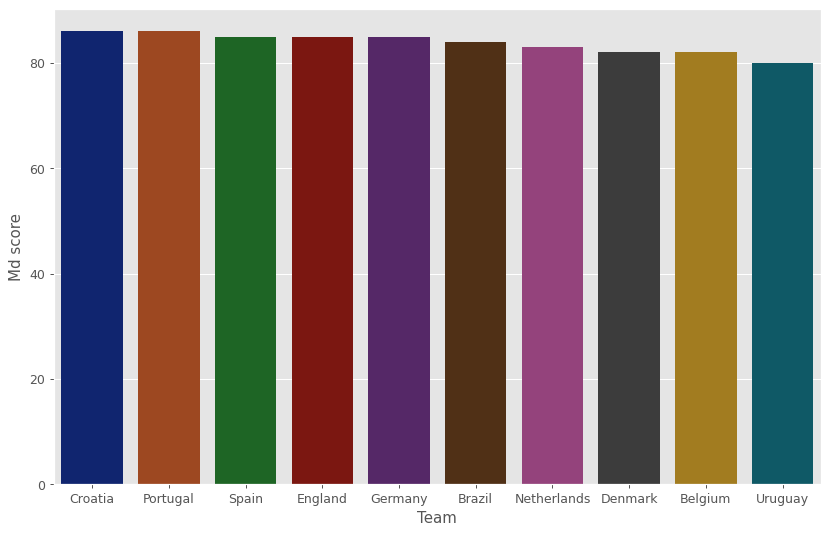

In [28]:
plt.figure(figsize=(11,7), dpi=90)
ax = sns.barplot(data=midfield_scores[:10], x='Team', y='Md score')
ax.bar_label(ax.containers[0])
plt.xlabel('TEAM')
plt.ylabel('SCORE')
plt.title('TOP 10 MIDFIELD SCORE');

In [29]:
offence_score = []
for x in teams_worldcup:
    of_score = np.round((df[df["home_team"]==x]['home_team_mean_offense_score'].mean() + df[df["away_team"]==x]['away_team_mean_offense_score'].mean())/2, 2)
    offence_score.append(of_score)

offence_scores = pd.DataFrame({'Team':teams_worldcup, 'Of score': offence_score}).sort_values('Of score', ascending=False).reset_index(drop=True)
offence_scores.index += 1
offence_scores

,Team,Of score
1,Poland,91.0
2,England,89.0
3,France,88.0
4,Germany,87.0
5,Argentina,87.0
6,Belgium,87.0
7,Brazil,86.0
8,Portugal,85.0
9,Netherlands,83.0
10,Uruguay,83.0


AttributeError: ignored

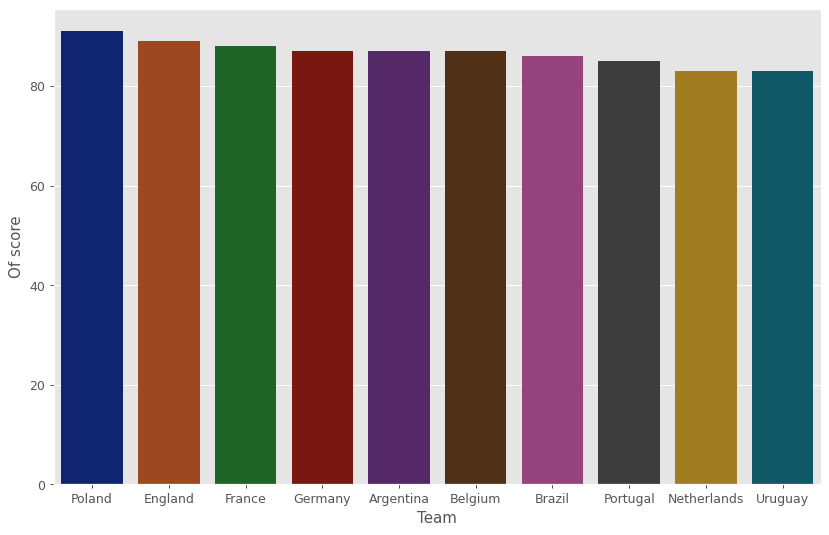

In [30]:
plt.figure(figsize=(11,7), dpi=90)
ax = sns.barplot(data=offence_scores[:10], x='Team', y='Of score')
ax.bar_label(ax.containers[0])
plt.xlabel('TEAM')
plt.ylabel('SCORE')
plt.title('TOP 10 OFFENCE SCORE');

# Group Stage Prediction

# Feature Extraction

In [31]:
match_df=df
match_df
                                                                                      
match_df['rank_difference'] = match_df['home_team_fifa_rank'] - match_df['away_team_fifa_rank']
match_df['average_rank'] = (match_df['home_team_fifa_rank'] + match_df['away_team_fifa_rank'])/2
match_df['point_difference'] = match_df['home_team_total_fifa_points'] - match_df['away_team_total_fifa_points']
match_df['is_stake'] = match_df['tournament'] != 'Friendly'
match_df['is_worldcup'] = 'FIFA World Cup' in match_df['tournament']
match_df['team_mean_position_score_difference']=match_df['home_sum']-match_df['away_sum']
       
match_df['score_difference'] = match_df['home_team_score']-match_df['away_team_score'] # Note that this feature is not used in training
match_df['is_won'] = match_df['score_difference'] > 0 # Take draw as lost

# Data Analysis(Model Training)

In [32]:
from sklearn import linear_model ## 선형모델
from sklearn import ensemble ## 앙상블 기법 (우리가 사용한 기법들 중에서 가장 최적 기법을 찾는 것을 말한다)
from sklearn.model_selection import train_test_split  #데이터의 순서를 섞고나서 훈련 데이터와 테스트 데이터를 분리합니다. 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score 
#분류결과표(Confusion Matrix)는 타겟의 원래 클래스와 모형이 예측한 클래스가 일치하는지는 갯수로 센 결과를 표나 나타낸 것이다.
######## 정답 클래스는 행(row)으로 예측한 클래스는 열(column)로 나타낸다.
from sklearn.pipeline import Pipeline ## 분석 파이프 라인 구성 
from sklearn.preprocessing import PolynomialFeatures #다항 회귀/훈련세트에 있는 각 특성들을 제곱하여 새로운 훈련데이터를 구성하는 방법 

# machine learning
from sklearn.linear_model import LogisticRegression ## 로지스틱 회귀 
from sklearn.svm import SVC, LinearSVC ## support vector 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import Perceptron ##퍼셉트론 기법(입력 값에 대해 가중치를 적용해 계산한 후, 확인해서 결과 전달)
from sklearn.linear_model import SGDClassifier ##Stochastic Gradient Descent
from sklearn.tree import DecisionTreeClassifier ##결정나무decision tree 기법 
from xgboost import XGBClassifier ## xgbboost 모듈 불러옴

In [33]:
X, y = match_df.loc[:,['average_rank', 'rank_difference', 'point_difference', 
                       'is_stake', 'is_worldcup','team_mean_position_score_difference']], match_df['is_won']
                       ## x= 독립변수(분석에서 고려하는 변수 )
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) ##전체 입력된 데이터세트의 20%를 테스트 데이터로 분할/무작위 분할(실행마다 같게 만들기 위해서) 

In [34]:
match_df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_sum,away_sum,year,home_win,home_draw,home_lose,rank_difference,average_rank,point_difference,is_stake,is_worldcup,team_mean_position_score_difference,score_difference,is_won
0,2018.7.22,Liberia,Sierra Leone,Africa,Africa,151,113,1126,1373,0,0,Friendly,Monrovia,Liberia,False,No,Draw,75.500974,74.759474,74.559121,76.231495,75.238234,73.971918,70.000000,74.612793,258.925743,70.00000,2018,False,True,False,38,132.0,-247,False,False,188.925743,0,False
1,2018.8.4,Belize,Barbados,North America,North America,163,162,1052,1059,1,0,Friendly,San Pedro,Belize,False,No,Win,75.500974,74.759474,74.559121,76.231495,75.238234,73.971918,75.188585,74.612793,258.925743,246.66099,2018,True,False,False,1,162.5,-7,False,False,12.264753,1,True
2,2018.8.4,Palestine,Iraq,Asia,Asia,101,84,1449,1534,0,3,Friendly,Al-Ram,Palestine,False,No,Lose,75.500974,74.759474,74.559121,76.231495,75.238234,73.971918,75.188585,69.500000,258.925743,69.50000,2018,False,False,True,17,92.5,-85,False,False,189.425743,-3,False
3,2018.8.15,Guatemala,Cuba,North America,North America,133,168,1263,1018,3,0,Friendly,Guatemala City,Guatemala,False,No,Win,72.000000,74.759474,74.559121,76.231495,75.238234,73.971918,75.188585,74.612793,72.000000,246.66099,2018,True,False,False,-35,150.5,245,False,False,-174.660990,3,True
4,2018.8.18,Andorra,United Arab Emirates,Europe,Asia,130,77,1120,1312,0,0,Friendly,GrÃ¶dig,Austria,True,No,Draw,75.500974,74.759474,74.559121,76.231495,75.238234,73.971918,75.188585,74.612793,258.925743,246.66099,2018,False,True,False,53,103.5,-192,False,False,12.264753,0,False


In [35]:
# Logistic Regression-소프트맥스(softmas) 함수를 사용한 다중 클래스 분류 알고리즘.이름은 회귀지만, 실제로는 분류를 수행

logreg = LogisticRegression() #로지스틱 회귀분석 모델 모듈 정의 변수
logreg.fit(X_train, y_train) ## 정의된 모델 변수에 학습 데이터를 적용함 
lg_pred = logreg.predict(X_test) ## 예측하고자 하는 변수데이터를 선언(학습 결과에서 예측하고자 하는 )
acc_log = round(logreg.score(X_test, y_test) * 100, 2) #정확도 산출 후 소수 둘째 자리까지 표현 
acc_log

67.44

In [36]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3) #매개변수 3개
knn.fit(X_train, y_train) # 훈련 데이터셋으로부터 모델을 만들려면 knn 객체의 fit 메서드를 사용한다.

Y_pred = knn.predict(X_test) # #테스트 데이터를 분류시킨다. 
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
acc_knn  #정확도

64.99

In [37]:
# train 점수 to choose K
trainList = []
for k in range(1,101):
    # 모델 선택 및 하이퍼 파라미터 튜닝
    model = KNeighborsClassifier(n_neighbors = k)
    # 모델학습
    model.fit(X_train, y_train)
    # 모델 평가
    trainList.append(model.score(X_train, y_train))
    print(f"이웃{k}개 : {trainList[k-1]}")

이웃1개 : 0.995311936530833
이웃2개 : 0.8092318788315903
이웃3개 : 0.8117562206996033
이웃4개 : 0.7731698521456906
이웃5개 : 0.7811034980165885
이웃6개 : 0.7612693833393437
이웃7개 : 0.7601875225387666
이웃8개 : 0.7551388388027407
이웃9개 : 0.7554994590695997
이웃10개 : 0.7385503065272269
이웃11개 : 0.7371078254597908
이웃12개 : 0.7316985214569058
이웃13개 : 0.7277316985214569
이웃14개 : 0.7302560403894699
이웃15개 : 0.7219617742517129
이웃16개 : 0.7216011539848539
이웃17개 : 0.717994951316264
이웃18개 : 0.7216011539848539
이웃19개 : 0.7194374323837
이웃20개 : 0.713667508113956
이웃21개 : 0.717273710782546
이웃22개 : 0.7194374323837
이웃23개 : 0.715109989181392
이웃24개 : 0.717273710782546
이웃25개 : 0.716913090515687
이웃26개 : 0.716552470248828
이웃27개 : 0.711864406779661
이웃28개 : 0.708979444644789
이웃29개 : 0.7107825459790841
이웃30개 : 0.7104219257122251
이웃31개 : 0.714028128380815
이웃32개 : 0.7075369635773531
이웃33개 : 0.708258204111071
이웃34개 : 0.709340064911648
이웃35개 : 0.711864406779661
이웃36개 : 0.711503786512802
이웃37개 : 0.7104219257122251
이웃38개 : 0.711143166245943
이웃39개

In [38]:
# Gaussian Naive Bayes # 각 특성을 개별로 취급해 파라미터를 학습하고 그 특성에서 클래스별 통계를 단순하게 취합시킨다.

gaussian = GaussianNB() # NB라는 객체에 GaussianNB()를 할당
gaussian.fit(X_train, y_train) # GaussianNB Classifier을 fit해줌 
gnb_pred = gaussian.predict(X_test) #테스트 데이터를 분류시킨다. 
acc_gaussian = round(gaussian.score(X_test, y_test) * 100, 2)
acc_gaussian #정확도

67.87

In [39]:
# Decision Tree-의사 결정을 할, 즉 데이터를 분리할 어떤 경계를 찾아내어 데이터를 체에 거르듯 한 단계씩 분류해나가는 모델

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train) #fit method로 해당 학습 데이터로 학습
Y_pred = decision_tree.predict(X_test) #예측
acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2) #예측 확률을 소수점 2번째 자리까지 반올림
acc_decision_tree

61.38

In [40]:
# Random Forest-상위 모델들이 예측하는 편향된 결과보다, 다양한 모델들의 결과를 반영함으로써 더 다양한 데이터에 대한 의사결정을 내릴 수 있게 함.

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train) #fit method로 해당 학습 데이터로 학습
Y_pred = random_forest.predict(X_test) #예측
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2) #예측 확률을 소수점 2번째 자리까지 반올림
acc_random_forest

67.0

In [41]:
#XGBoost

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train) #fit method로 해당 학습 데이터로 학습
xgbc_pred=xgbc.predict(X_test) #예측
acc_xgbc=round(xgbc.score(X_test, y_test) * 100, 2) #예측 확률을 소수점 2번째 자리까지 반올림
acc_xgbc

69.74

In [42]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Decision Tree','XGBoost'],
    'Score': [acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, 
              acc_decision_tree, acc_xgbc]})
models.sort_values(by='Score', ascending=False)  #내림차순

,Model,Score
5,XGBoost,69.74
3,Naive Bayes,67.87
1,Logistic Regression,67.44
2,Random Forest,67.00
0,KNN,64.99
4,Decision Tree,61.38


In [43]:
model = xgbc #확률이 가장 높은 모델 선택 및 생성

In [44]:
rank_df = pd.read_csv("/content/drive/MyDrive/kaggle2/fifa_ranking-2022-10-06-edit_na1.csv")
teams_df = pd.read_csv("/content/drive/MyDrive/kaggle2/Qatar2022-teams (1).csv", sep=";")

match_df = match_df.replace({"IR Iran": "Iran", "Korea Republic" : "South Korea"})
rank_df = rank_df.replace({"IR Iran": "Iran", "Korea Republic" : "South Korea"})

In [45]:
# 월드컵 랭킹 define
rank_df = rank_df.loc[(rank_df['rank_date'] == rank_df['rank_date'].max()) & 
                      (rank_df['country_full'].isin(teams_df['Team'].unique()))]

worldcup_rankings = rank_df.set_index(['country_full'])

In [46]:
print(worldcup_rankings)

              rank country_abrv  total_points  previous_points  rank_change  \
country_full                                                                  
Brazil           1          BRA       1837.56          1837.56            0   
Belgium          2          BEL       1821.92          1821.92            0   
Tunisia         30          TUN       1507.86          1507.86            0   
Costa Rica      34          CRC       1500.06          1500.06            0   
Cameroon        38          CMR       1484.95          1484.95            0   
Australia       39          AUS       1483.73          1483.73            0   
Canada          43          CAN       1473.82          1473.82            0   
Ecuador         44          ECU       1463.74          1463.74            0   
Qatar           48          QAT       1441.97          1441.41           -1   
South Korea     28          KOR       1526.02          1526.20            0   
Poland          26          POL       1546.18       

In [47]:
worldcup_rankings.head()

,rank,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,sum
country_full,,,,,,,,,,,,
Brazil,1,BRA,1837.56,1837.56,0,CONMEBOL,2022.8.25,89.0,84.0,86.0,84.0,343.0
Belgium,2,BEL,1821.92,1821.92,0,UEFA,2022.8.25,90.0,87.0,80.0,85.0,342.0
Tunisia,30,TUN,1507.86,1507.86,0,CAF,2022.8.25,66.0,70.0,71.0,73.0,280.0
Costa Rica,34,CRC,1500.06,1500.06,0,CONCACAF,2022.8.25,88.0,70.0,72.0,74.0,304.0
Cameroon,38,CMR,1484.95,1484.95,0,CAF,2022.8.25,82.0,73.0,76.0,69.0,300.0


In [48]:
worldcup_rankings.index.unique()

Index(['Brazil', 'Belgium', 'Tunisia', 'Costa Rica', 'Cameroon', 'Australia',
       'Canada', 'Ecuador', 'Qatar', 'South Korea', 'Poland', 'France',
       'England', 'Spain', 'Netherlands', 'Portugal', 'Denmark', 'Germany',
       'Mexico', 'Uruguay', 'USA', 'Croatia', 'Switzerland', 'Senegal',
       'Wales', 'Iran', 'Morocco', 'Japan', 'Serbia', 'Saudi Arabia',
       'Argentina', 'Ghana'],
      dtype='object', name='country_full')

In [49]:
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup = teams_df.set_index(['Team'])
world_cup['points'] = 0
world_cup['total_prob'] = 0
world_cup['expected points'] = 0
world_cup['rank'] = None

country_win_prob = {}

for country in teams_df['Team'].unique():
    country_win_prob[country] = list()

In [50]:
#rank_df.fillna(rank_df.mean())
rank_df.fillna(0) #비출전국가들 0처리

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,sum
211,1,Brazil,BRA,1837.56,1837.56,0,CONMEBOL,2022.8.25,89.0,84.0,86.0,84.0,343.0
212,2,Belgium,BEL,1821.92,1821.92,0,UEFA,2022.8.25,90.0,87.0,80.0,85.0,342.0
319,30,Tunisia,TUN,1507.86,1507.86,0,CAF,2022.8.25,66.0,70.0,71.0,73.0,280.0
323,34,Costa Rica,CRC,1500.06,1500.06,0,CONCACAF,2022.8.25,88.0,70.0,72.0,74.0,304.0
327,38,Cameroon,CMR,1484.95,1484.95,0,CAF,2022.8.25,82.0,73.0,76.0,69.0,300.0
328,39,Australia,AUS,1483.73,1483.73,0,AFC,2022.8.25,78.0,69.0,70.0,73.0,290.0
332,43,Canada,CAN,1473.82,1473.82,0,CONCACAF,2022.8.25,77.0,70.0,77.0,77.0,301.0
333,44,Ecuador,ECU,1463.74,1463.74,0,CONMEBOL,2022.8.25,70.0,74.0,76.0,70.0,290.0
337,48,Qatar,QAT,1441.97,1441.41,-1,AFC,2022.8.25,68.0,68.0,74.0,72.0,282.0
342,28,South Korea,KOR,1526.02,1526.20,0,AFC,2022.8.25,70.0,73.0,81.0,74.0,298.0


# 경기결과(Predictions)

In [51]:
from itertools import combinations
import numpy as np

df=df.fillna(df.mean()) 

# let's define a small margin when we safer to predict draw then win 
margin = 0.16


for group in set(teams_df['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(teams_df.query('Group == "{}"'.format(group)).values, 2):
        print("{} vs. {}: ".format(home[0], away[0]), end='')
    
        home = home[0]
        away = away[0]
        
        # Create a row for each match
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True, True, True]]), columns=X_train.columns)

        home_rank = worldcup_rankings.loc[home, 'rank']
        home_points = worldcup_rankings.loc[home, 'total_points']
        opp_rank = worldcup_rankings.loc[away, 'rank']
        opp_points = worldcup_rankings.loc[away, 'total_points']
        world_cup.loc[home, 'rank'] = home_rank
        world_cup.loc[away, 'rank'] = opp_rank
        
        home_pos = worldcup_rankings.loc[home, 'sum']
        away_pos = worldcup_rankings.loc[away, 'sum']
        

        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['team_mean_position_score_difference']=home_pos-away_pos
        
       
        
        # Model Output
        home_win_prob = model.predict_proba(row)[:,1][0]

    
        # Saving Model Output
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob

        country_win_prob[home].append(home_win_prob)
        country_win_prob[away].append(1-home_win_prob)
        
        # Determining Win / Draw / Lose based on home_win_prob, 0.34/0.31/0.34
        points = 0
        if home_win_prob <= 0.5 - margin: #0.34이하 패배 - 승점 0점
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
            world_cup.loc[away, 'expected points'] += (1-home_win_prob) * 3
        if home_win_prob > 0.5 - margin: #0.34초과 0.66미만 무승부 - 승점 1점
            points = 1
        if home_win_prob >= 0.5 + margin: #0.66이상 승리 - 승점 3점
            points = 3
            world_cup.loc[home, 'points'] += 3
            world_cup.loc[home, 'expected points'] += home_win_prob * 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            world_cup.loc[home, 'expected points'] += home_win_prob * 1
            world_cup.loc[away, 'expected points'] += (1-home_win_prob) * 1
        

___Starting group B:___
Iran vs. England: England wins with 0.90
Iran vs. USA: USA wins with 0.69
Iran vs. Wales: Draw
England vs. USA: Draw
England vs. Wales: England wins with 0.80
USA vs. Wales: Draw
___Starting group E:___
Germany vs. Japan: Draw
Germany vs. Spain: Draw
Germany vs. Costa Rica: Germany wins with 0.75
Japan vs. Spain: Spain wins with 0.89
Japan vs. Costa Rica: Costa Rica wins with 0.68
Spain vs. Costa Rica: Spain wins with 0.76
___Starting group F:___
Morocco vs. Croatia: Croatia wins with 0.69
Morocco vs. Belgium: Belgium wins with 0.81
Morocco vs. Canada: Draw
Croatia vs. Belgium: Belgium wins with 0.83
Croatia vs. Canada: Croatia wins with 0.71
Belgium vs. Canada: Belgium wins with 0.85
___Starting group D:___
Denmark vs. Tunisia: Denmark wins with 0.75
Denmark vs. France: Draw
Denmark vs. Australia: Denmark wins with 0.76
Tunisia vs. France: France wins with 0.91
Tunisia vs. Australia: Australia wins with 0.68
France vs. Australia: France wins with 0.85
___Starti

In [52]:
for group in set(teams_df['Group']):
    print('___Starting group {}:___'.format(group))
    teams = teams_df.query('Group == "{}"'.format(group)).values
    for team_info in teams:
        team_name = team_info[0]
        print(team_name, ": ", world_cup.loc[team_name, "expected points"])

___Starting group B:___
Iran :  0.35730141401290894
England :  5.720003470778465
USA :  2.879931151866913
Wales :  1.2164252698421478
___Starting group E:___
Germany :  3.261010318994522
Japan :  0.3863055109977722
Spain :  5.566194117069244
Costa Rica :  2.0443762242794037
___Starting group F:___
Morocco :  0.504021942615509
Croatia :  4.207959741353989
Belgium :  7.482262015342712
Canada :  0.49597805738449097
___Starting group D:___
Denmark :  4.908360660076141
Tunisia :  0.0
France :  5.8924382999539375
Australia :  2.0443762242794037
___Starting group A:___
Senegal :  2.842073380947113
Qatar :  0.4520447850227356
Netherlands :  7.284043326973915
Ecuador :  0.9794566631317139
___Starting group C:___
Argentina :  3.7058783173561096
Saudi Arabia :  0.0
Mexico :  3.514740400016308
Poland :  3.190618246793747
___Starting group H:___
Uruguay :  2.818612217903137
South Korea :  1.012904942035675
Portugal :  7.176734626293182
Ghana :  0.437602162361145
___Starting group G:___
Switzerland 

In [53]:
country_total_prob = []

for country in country_win_prob.keys():

    win_prob_list = country_win_prob[country]

    total_prob = 0
    temp = 1
    for i in range(3):
        temp = temp * win_prob_list[i]

    total_prob += temp

    for i in range(3):
        temp = 1
        for j in range(3):
            if i == j:
                temp = temp * (1 - win_prob_list[i])
            else:
                temp = temp * win_prob_list[i]
        total_prob += temp
    
    country_total_prob.append((country, total_prob))
    
    print(country, ":", total_prob)

Senegal : 0.4237373617461311
Qatar : 0.18163567877636222
Netherlands : 0.8897629077662201
Ecuador : 0.32952309885510545
Iran : 0.16704088427764094
England : 0.8027515989923046
USA : 0.45158128327185254
Wales : 0.3956551401722923
Argentina : 0.7111482145146868
Saudi Arabia : 0.08575946605985323
Mexico : 0.46116183091843344
Poland : 0.5271328435415953
Denmark : 0.5831732682991231
Tunisia : 0.13152511198405387
France : 0.8103138474001721
Australia : 0.2353792479016167
Germany : 0.5594282660650058
Japan : 0.18515195952790195
Spain : 0.7835321087433671
Costa Rica : 0.27714154904929134
Morocco : 0.24819653224881355
Croatia : 0.3996414138265808
Belgium : 0.9232929114776072
Canada : 0.22533543893168426
Switzerland : 0.25848531597482904
Cameroon : 0.18189089187241012
Brazil : 0.9645781073591096
Serbia : 0.3612421053343474
Uruguay : 0.4845406875141066
South Korea : 0.28873951461082503
Portugal : 0.8485322703447701
Ghana : 0.19422936823051684


# Group Stage Survival Probability

In [54]:
country_total_prob = sorted(country_total_prob, key=lambda x: x[1], reverse=True)
#파이썬 정렬 함수 reverse=True이므로 내림차순으로 정렬
country_total_prob

[('Brazil', 0.9645781073591096),
 ('Belgium', 0.9232929114776072),
 ('Netherlands', 0.8897629077662201),
 ('Portugal', 0.8485322703447701),
 ('France', 0.8103138474001721),
 ('England', 0.8027515989923046),
 ('Spain', 0.7835321087433671),
 ('Argentina', 0.7111482145146868),
 ('Denmark', 0.5831732682991231),
 ('Germany', 0.5594282660650058),
 ('Poland', 0.5271328435415953),
 ('Uruguay', 0.4845406875141066),
 ('Mexico', 0.46116183091843344),
 ('USA', 0.45158128327185254),
 ('Senegal', 0.4237373617461311),
 ('Croatia', 0.3996414138265808),
 ('Wales', 0.3956551401722923),
 ('Serbia', 0.3612421053343474),
 ('Ecuador', 0.32952309885510545),
 ('South Korea', 0.28873951461082503),
 ('Costa Rica', 0.27714154904929134),
 ('Switzerland', 0.25848531597482904),
 ('Morocco', 0.24819653224881355),
 ('Australia', 0.2353792479016167),
 ('Canada', 0.22533543893168426),
 ('Ghana', 0.19422936823051684),
 ('Japan', 0.18515195952790195),
 ('Cameroon', 0.18189089187241012),
 ('Qatar', 0.18163567877636222),
 

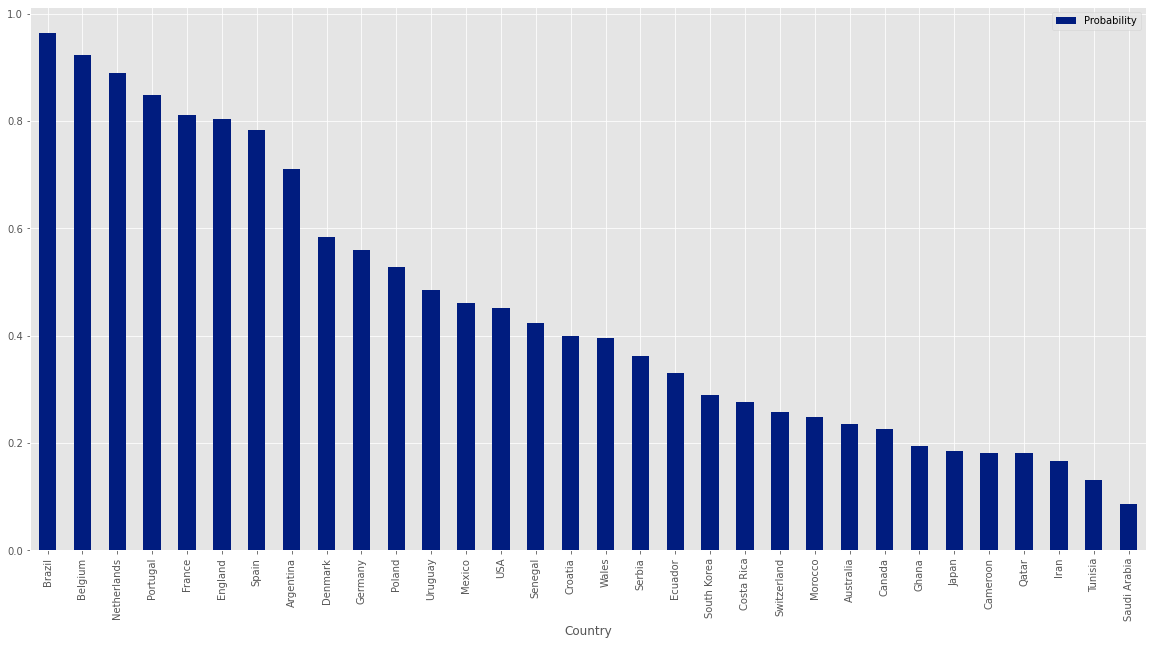

In [55]:
#막대그래프로 시각화 승률 높은 순위로 나열
prob_df = pd.DataFrame(country_total_prob, columns =['Country', 'Probability']) 

prob_df.plot(x="Country", y="Probability", kind="bar", figsize=(20,10))